In [2]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
pjr3.py complete


See really good discussion of spectral element grids at https://acme-climate.atlassian.net/wiki/spaces/DOC/pages/34113147/SE+Atmosphere+Grid+Overview+EAM+CAM

In [3]:
print ("two vals of pi", np.pi, pi)

two vals of pi 3.141592653589793 3.141592653589793


$$
f(t) = \Sigma_i (a_i cos({2\pi\over i} t) + b_i sin({2\pi\over i} t)))
$$


In [4]:
findNiceContours?

Signature: findNiceContours(data, nlevs=None, rmClev=None, sym=None, verbose=None)
Docstring:
Find Nice Contours
data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure)
nlevs = approximate number of contour levels to return (default 10)
rmClev = if defined delete the contour level near this value
sym = if defined make the contour intervals symmetric about zero
verbose = if defined, print out some info to help debug
File:      ~/Python/pjr3.py
Type:      function


In [5]:
plotZMf?

Signature:
plotZMf(
    data,
    x,
    y,
    plotOpt=None,
    modelLevels=None,
    surfacePressure=None,
    axesa=None,
    fig=None,
)
Docstring:
Create a zonal mean contour plot of one variable
axesa = the axes that we make the plot on 
data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure)
x = 1d numpy array of latitude
y = 1d numpy array of pressures (or pseudo pressure (like eta))
plotOpt is a optional dictionary with plotting options:
  'scale_factor': multiply values with this factor before plotting
  'units': a units label for the colorbar
  'clevs': use list of values as contour intervals
  'cmap': the color map to use
  'cabv': the above color
  'cbel': the below color
  'colorbar': location of colorbar ('bot','top','left','right','None')
  'rmClev': contour level to delete; frequently Zero, see findNiceContours
  'title': a title for the plot
  'ybot': if present, the pressure at the plot bottom
  'ytop': if present, the pressure at the to

In [6]:
from nco import Nco

In [7]:
# identify a model case directory, and a directory to store remapped climo files
import os
#host = os.environ.get('HOST')
#print(host)
#print(os.environ)
import platform
host = platform.node()
print(host)
filename = os.path.expanduser('~/my_folder/output.txt')
if ('cori' in host):
    indir = '/global/cfs/cdirs/e3sm/wlin/E3SM_simulations/DECKv1/20180215.DECKv1b_H1.ne30_oEC.edison/archive/atm/hist/20180215.DECKv1b_H1.ne30_oEC.edison.cam.h0.2014-12.nc'
    gridfile = '/global/cfs/cdirs/e3sm/mapping/grids/ne30np4_pentagons.091226.nc'
    else:
    indir = os.path.expanduser('~/NetCDF_Files/vd05_ANN_climo.nc')
    gridfile = '/global/cfs/cdirs/e3sm/mapping/grids/ne30np4_pentagons.091226.nc'

print(indir)
#print('exists',os.path.exists(indir))
DS = xr.open_mfdataset(indir).chunk({'time': 20})
#print(DS)
weights = DS.area
weights.name = 'weights'
#print(weights)
#print(weights.sum(),4.*pi)
#Var = DS.FSNT.isel(time=0)
Var = DS.PHIS
print(Var.shape)

ds_grid = xr.open_dataset(gridfile).rename({'grid_size': 'ncol'})
lon_edges = ds_grid['grid_corner_lon']
lat_edges = ds_grid['grid_corner_lat']
data = Var.squeeze()
print('data',data)

sooty.pnl.gov
/home/d3x345/NetCDF_Files/vd05_ANN_climo.nc
(1, 192, 288)


FileNotFoundError: [Errno 2] No such file or directory: b'/global/cfs/cdirs/e3sm/mapping/grids/ne30np4_pentagons.091226.nc'

In [26]:
from matplotlib import pyplot
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection, PolyCollection
from cartopy import crs
import numpy
import xarray


def plot_unstructured(xv, yv, data, antialiased=False, **kwargs):
    """
    Plot unstructured data. xv and yv specify the x and y coordinates
    of the vertices of each cell and should have shape [ni,nv] where ni
    is the size of the grid (number of cells) and nv is the number of
    vertices for each cell. Data contains the values of the data you
    want to plot, and should have dimension [ni,]. The intent with this
    function is that you will need to read in an auxillary SCRIP-format
    file that describes the grid (unless this information is present in
    the same file that contains the data; unlikely) as well as the file
    that contains the data, and grab the cell corner information from
    the SCRIP file and the data from the data file. This function will
    then plot the data on the native grid by looping over each cell and
    drawing patches for each. Note that this will probably be really
    slow for big grids! Seems to work alright up to about ne120 or so,
    but really some more clever techniques should probably be used here
    (parallelism?).
    
    NOTE: To avoid artifacts due to antialiasing, you should probably pass
    antialiaseds=False to **kwargs.
    """

# Create array of cell vertices, indexed [npoints, ncorners, 2]
    corners = numpy.stack([xv, yv], axis=2)

    # Go back and fix corners where they wrap; we shouldn't have to do
    # this with cartopy, but it seems we do...
    for i in range(corners.shape[0]):
        if any(corners[i,:,0] < -90) and any(corners[i,:,0] > 90):
            corners[i,:,0] = numpy.where(corners[i,:,0] < -90, corners[i,:,0] + 360, corners[i,:,0])
        if any(corners[i,:,1] < -45) and any(corners[i,:,1] > 45):
            corners[i,:,1] = numpy.where(corners[i,:,1] < -45, corners[i,:,1] + 90, corners[i,:,1])

    # Create a PatchCollection from our aggregated list of PathPatches
    p = PolyCollection(corners, array=data, antialiaseds=antialiased, **kwargs)
#    colors = 100*np.random.rand(len(data))
#    p.set_array(np.array(colors))

    # Add the collection to the axes
    ax = pyplot.gca()
    ax.add_collection(p)

    # Set sane axes limits
    ax.set_xlim([xv.min(), xv.max()])
    ax.set_ylim([yv.min(), yv.max()])

    # Return collection of patches
    return p


# Function to convert longitude from 0-360 to -180 to 180
def fix_lon(lon):
    return numpy.where(lon > 180, lon - 360, lon)



lon_edges <xarray.DataArray 'grid_corner_lon' (ncol: 48602, grid_corners: 5)>
[243010 values with dtype=float64]
Dimensions without coordinates: ncol, grid_corners
Attributes:
    units:    degrees
plotfile PHIS_example.png


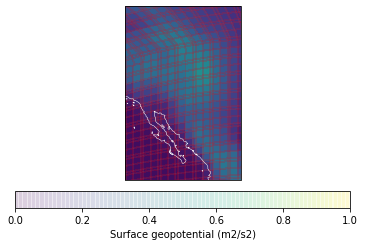

In [27]:


ds_grid = xarray.open_dataset(gridfile).rename({'grid_size': 'ncol'})
lon_edges = ds_grid['grid_corner_lon']
lat_edges = ds_grid['grid_corner_lat']

print('lon_edges',lon_edges)
varname = data.name
# Reduce data if we need to
if 'time' in data.dims: data = data.isel(time=0).squeeze()
if 'lev' in data.dims: data = data.isel(lev=-1).squeeze()

# Make plot
figure, ax = pyplot.subplots(
    1, 1,
    #subplot_kw=dict(projection=crs.Orthographic(central_longitude=-100))
    subplot_kw=dict(projection=crs.PlateCarree())
)
dd = data.values
pl = plot_unstructured(
    fix_lon(lon_edges.values), lat_edges.values, dd,
    transform=crs.PlateCarree()#,ec='red',alpha=0.1
)
pl = plot_unstructured(
    fix_lon(lon_edges.values), lat_edges.values, data=None,
    transform=crs.PlateCarree(),ec='red',alpha=0.1
)
ax.set_global()
#ax.set_extent([-180, -100, 0, 80], crs=ccrs.PlateCarree())
ax.set_extent([-120, -100, 20, 50], crs=ccrs.PlateCarree())
ax.coastlines(color='white', linewidth=0.5)

# Add colorbar to plot
cb = pyplot.colorbar(
    pl, orientation='horizontal',
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)

if False: '''
# Add markers to plot for GLL centers
pl = ax.plot(
    fix_lon(ds_grid['grid_center_lon'].values),
    ds_grid['grid_center_lat'].values,
    marker=',', markersize=0.5,
    MarkerFaceColor='black', MarkerEdgeColor='black',
    linestyle='none',
)
'''
#plt.show()
# Save plot
plotfile = '%s_example.png'%varname
figure.savefig(plotfile, bbox_inches='tight')
print('plotfile',plotfile)

lon_edges <xarray.DataArray 'grid_corner_lon' (ncol: 1536, grid_corners: 5)>
array([[315.      , 320.455677, 320.494849, 315.      , 315.      ],
       [320.455677, 326.25    , 326.25    , 320.494849, 320.455677],
       [315.      , 320.494849, 320.529772, 315.      , 315.      ],
       ...,
       [129.056711, 123.75    , 129.544323, 135.      , 129.056711],
       [140.943289, 135.      , 140.455677, 146.25    , 140.943289],
       [135.      , 129.544323, 135.      , 140.455677, 135.      ]])
Dimensions without coordinates: ncol, grid_corners
Attributes:
    units:    degrees
done


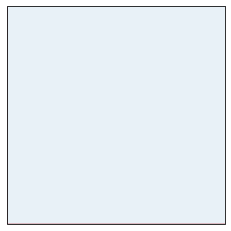

In [35]:
gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne4pg2_scrip_c20191218.nc'
#gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne30pg2_scrip_c20191218.nc'
gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne8pg2_scrip_c20191218.nc'
gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne16pg2_scrip_c20191218.nc'
ds_gridlr = xr.open_dataset(gridfilelr).rename({'grid_size': 'ncol'})
lon_edgeslr = ds_gridlr['grid_corner_lon']
lat_edgeslr = ds_gridlr['grid_corner_lat']

print('lon_edges',lon_edgeslr)
figure, ax = pyplot.subplots(
    1, 1,
    #subplot_kw=dict(projection=crs.Orthographic(central_longitude=-100))
#   subplot_kw=dict(projection=crs.PlateCarree())
    subplot_kw=dict(projection=crs.NearsidePerspective(central_longitude=0.0, central_latitude=0.0))
)

#ax.set_global()
#ax.set_extent([-180, -100, 0, 80], crs=ccrs.PlateCarree())
#ax.set_extent([-120, -100, 20, 50], crs=ccrs.PlateCarree())
ax.coastlines(color='black', linewidth=0.5)

print('done')

def plot_unstructured(xv, yv, data, antialiased=False, **kwargs):
    """
    Plot unstructured data. xv and yv specify the x and y coordinates
    of the vertices of each cell and should have shape [ni,nv] where ni
    is the size of the grid (number of cells) and nv is the number of
    vertices for each cell. Data contains the values of the data you
    want to plot, and should have dimension [ni,]. The intent with this
    function is that you will need to read in an auxillary SCRIP-format
    file that describes the grid (unless this information is present in
    the same file that contains the data; unlikely) as well as the file
    that contains the data, and grab the cell corner information from
    the SCRIP file and the data from the data file. This function will
    then plot the data on the native grid by looping over each cell and
    drawing patches for each. Note that this will probably be really
    slow for big grids! Seems to work alright up to about ne120 or so,
    but really some more clever techniques should probably be used here
    (parallelism?).
    
    NOTE: To avoid artifacts due to antialiasing, you should probably pass
    antialiaseds=False to **kwargs.
    """

# Create array of cell vertices, indexed [npoints, ncorners, 2]
    corners = numpy.stack([xv, yv], axis=2)

    # Go back and fix corners where they wrap; we shouldn't have to do
    # this with cartopy, but it seems we do...
    for i in range(corners.shape[0]):
        if any(corners[i,:,0] < -90) and any(corners[i,:,0] > 90):
            corners[i,:,0] = numpy.where(corners[i,:,0] < -90, corners[i,:,0] + 360, corners[i,:,0])
        if any(corners[i,:,1] < -45) and any(corners[i,:,1] > 45):
            corners[i,:,1] = numpy.where(corners[i,:,1] < -45, corners[i,:,1] + 90, corners[i,:,1])

    # Create a PatchCollection from our aggregated list of PathPatches
    p = PolyCollection(corners, array=data, antialiaseds=antialiased, **kwargs)
#    colors = 100*np.random.rand(len(data))
#    p.set_array(np.array(colors))

    # Add the collection to the axes
    ax = pyplot.gca()
    ax.add_collection(p)

    # Set sane axes limits
    #ax.set_xlim([xv.min(), xv.max()])
    #ax.set_ylim([yv.min(), yv.max()])

    # Return collection of patches
    return p

pl = plot_unstructured(
    fix_lon(lon_edgeslr.values), lat_edgeslr.values, data=None,
    transform=crs.NearsidePerspective(central_longitude=0.0, central_latitude=0.0),ec='red',alpha=0.1
    #transform=crs.PlateCarree(),ec='red',alpha=0.1

)
plt.show()

winding False


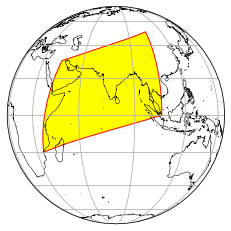

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

map_proj = ccrs.Orthographic(central_latitude=0.0, central_longitude=80.0)

map_proj._threshold /= 100.  # the default values is bad, users need to set them manually

ax = plt.axes(projection=map_proj)

ax.set_global() # added following an answer to my question
ax.gridlines()

ax.coastlines(linewidth=0.5, color='k', resolution='50m')

lat_corners = np.array([-20.,  0., 50., 30.])
lon_corners = np.array([ 20., 90., 90., 30.]) + 15.0 # offset from gridline for clarity

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners
def is_clockwise(points):
    # points is your list (or array) of 2d points.
    assert len(points) > 0
    s = 0.0
    for p1, p2 in zip(points, points[1:] + [points[0]]):
        s += (p2[0] - p1[0]) * (p2[1] + p1[1])
    return s > 0.0

print('winding', is_clockwise(poly_corners))

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", transform=ccrs.PlateCarree())
#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", transform=ccrs.Geodetic())
#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False, lw=1, fc="yellow", transform=ccrs.Geodetic())

ax.add_patch(poly)

plt.show()

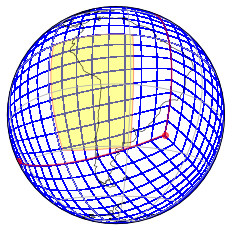

In [256]:
# based upon code suggested in https://stackoverflow.com/questions/59020032/how-to-plot-a-filled-polygon-on-a-map-in-cartopy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

#gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne30pg2_scrip_c20191218.nc'
gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne8pg2_scrip_c20191218.nc'
#gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne16pg2_scrip_c20191218.nc'
#gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne4np4-pentagons_c100308.nc'
#gridfilelr = '/global/cfs/cdirs/e3sm/mapping/grids/ne4pg2_scrip_c20191218.nc'


ds_gridlr = xr.open_dataset(gridfilelr).rename({'grid_size': 'ncol'})
lon_edgeslr = ds_gridlr['grid_corner_lon']
lat_edgeslr = ds_gridlr['grid_corner_lat']

#map_proj = ccrs.Orthographic(central_latitude=-45.0, central_longitude=-45.0)
map_proj = ccrs.NearsidePerspective(central_longitude=-65.0, central_latitude=-30.0, satellite_height=3.5785831e7*0.2)

map_proj._threshold /= 100.  # the default values is bad, users need to set them manually

ax = plt.axes(projection=map_proj)

ax.set_global() # added following an answer to my question
ax.gridlines()

ax.coastlines(linewidth=0.5, color='k', resolution='110m')

lat_corners = np.array([-40.,  -40., 0., 0.])
lon_corners = np.array([ -90., -60., -60., -90.]) + 1.0 # offset from gridline for clarity

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", transform=ccrs.Orthographic(central_latitude=0.0, central_longitude=80.0))
poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", transform=ccrs.Geodetic(),alpha=0.4)


ax.add_patch(poly)


#plt.show()

#1./0.

def plot_unstructured(xv, yv, data, antialiased=False, **kwargs):
    """
    Plot unstructured data. xv and yv specify the x and y coordinates
    of the vertices of each cell and should have shape [ni,nv] where ni
    is the size of the grid (number of cells) and nv is the number of
    vertices for each cell. Data contains the values of the data you
    want to plot, and should have dimension [ni,]. The intent with this
    function is that you will need to read in an auxillary SCRIP-format
    file that describes the grid (unless this information is present in
    the same file that contains the data; unlikely) as well as the file
    that contains the data, and grab the cell corner information from
    the SCRIP file and the data from the data file. This function will
    then plot the data on the native grid by looping over each cell and
    drawing patches for each. Note that this will probably be really
    slow for big grids! Seems to work alright up to about ne120 or so,
    but really some more clever techniques should probably be used here
    (parallelism?).
    
    NOTE: To avoid artifacts due to antialiasing, you should probably pass
    antialiaseds=False to **kwargs.
    """

# Create array of cell vertices, indexed [npoints, ncorners, 2]
    corners = numpy.stack([xv, yv], axis=2)

    # Go back and fix corners where they wrap; we shouldn't have to do
    # this with cartopy, but it seems we do...
    for i in range(corners.shape[0]):
        if any(corners[i,:,0] < -90) and any(corners[i,:,0] > 90):
            corners[i,:,0] = numpy.where(corners[i,:,0] < -90, corners[i,:,0] + 360, corners[i,:,0])
        if any(corners[i,:,1] < -45) and any(corners[i,:,1] > 45):
            corners[i,:,1] = numpy.where(corners[i,:,1] < -45, corners[i,:,1] + 90, corners[i,:,1])

    # Create a PatchCollection from our aggregated list of PathPatches
    p = PolyCollection(corners, array=data, antialiaseds=antialiased, **kwargs)
#    colors = 100*np.random.rand(len(data))
#    p.set_array(np.array(colors))
    p.set_facecolor('none')
    # Add the collection to the axes
    ax.add_collection(p)
    xv2 = corners[:,:,0]
    yv2 = corners[:,:,1]
#    ax.plot(xv2, yv2, marker='x',ls='', color='green',transform=crs.Geodetic())


    # Set sane axes limits
    #ax.set_xlim([xv.min(), xv.max()])
    #ax.set_ylim([yv.min(), yv.max()])

    # Return collection of patches
    return p

pl = plot_unstructured(
    fix_lon(lon_edgeslr.values), lat_edgeslr.values, data=None,
    transform=crs.Geodetic(),ec='blue',alpha=1.0,lw=0.5
    #transform=crs.PlateCarree(),ec='red',alpha=1.

)

cube_lat = np.array([35.,35.,-35.,-35.])
cube_lon = np.array([-90.,0.,0.,-90.])-45.0
poly_corners = np.zeros((len(cube_lat), 2), np.float64)
poly_corners[:,0] = cube_lon
poly_corners[:,1] = cube_lat
ax.plot(cube_lon, cube_lat, marker='o', color='red',alpha = 0.6, transform=crs.Geodetic())
#ax.plot(cube_lon, cube_lat, marker='o', color='red',transform=map_proj)

#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", transform=ccrs.Orthographic(central_latitude=0.0, central_longitude=80.0))
#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False, lw=1, transform=ccrs.Geodetic(),alpha=1.0)
#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False, lw=1, transform=ccrs.PlateCarree(),alpha=1.0)


#ax.add_patch(poly)



#plt.show()
# Save plot
#plotfile = '%s_example.png'%varname
plotfile = 'test.pdf'
plt.savefig(plotfile, bbox_inches='tight')
plt.show()

<ipython-input-65-44ad5f672874>:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pl = ax.plot(


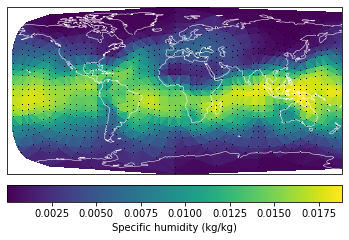

In [65]:
from matplotlib import pyplot
from cartopy import crs
import numpy
import xarray


# Function to convert longitude from 0-360 to -180 to 180
def fix_lon(lon):
        return numpy.where(lon > 180, lon - 360, lon)


datafile = '/global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/cami_mam3_Linoz_ne4np4_L72_c160909.nc'
gridfile = '/global/cfs/cdirs/e3sm/mapping/grids/ne4np4-pentagons_c100308.nc'
varname = 'Q'

# Read data
ds_data = xarray.open_dataset(datafile)
data = ds_data[varname]
lon = ds_data['lon']
lat = ds_data['lat']



# Reduce data if we need to
if 'time' in data.dims: data = data.isel(time=0).squeeze()
if 'lev' in data.dims: data = data.isel(lev=-1).squeeze()

# Make plot
figure, ax = pyplot.subplots(
    1, 1,
    #subplot_kw=dict(projection=crs.Orthographic(central_longitude=-100))
    subplot_kw=dict(projection=crs.PlateCarree())
)
pl = ax.tripcolor(
    fix_lon(lon.values), lat.values, data.values,
    transform=crs.PlateCarree()
)
ax.set_global()
ax.coastlines(color='white', linewidth=0.5)

# Add colorbar to plot
cb = pyplot.colorbar(
    pl, orientation='horizontal',
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)

# Add markers to plot for GLL centers
pl = ax.plot(
    fix_lon(lon.values),
    lat.values,
    marker=',', markersize=0.5,
    MarkerFaceColor='black', MarkerEdgeColor='black',
    linestyle='none',
)

plt.show()
# Save plot
#plotfile = '%s_tri_example.png'%varname
#figure.savefig(plotfile, bbox_inches='tight')

<function matplotlib.pyplot.show(close=None, block=None)>

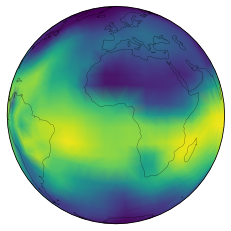

In [66]:
dataproj=crs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=crs.Orthographic()   # any projections should work 
ax = pyplot.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)

tcoords = plotproj.transform_points(dataproj,np.array(lon[:]),np.array(lat[:]))
data2d = data
xi=tcoords[:,0]!=numpy.inf
tc=tcoords[xi,:]
datai=data2d[:][xi]  # convert to numpy array, then subset
pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='gouraud') # looks good
#pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='flat') # looks bad
plt.show

xxx <xarray.DataArray 'grid_corner_lon' (ncol: 866, grid_corners: 5)>
array([[315.      , 315.      , 317.610476, 312.389524, 312.389524],
       [315.      , 323.86363 , 325.420168, 317.610476, 317.610476],
       [323.86363 , 334.556702, 335.829544, 325.420168, 325.420168],
       ...,
       [124.597095, 115.443298, 126.13637 , 133.286316, 133.286316],
       [145.402905, 136.713684, 143.86363 , 154.556702, 154.556702],
       [133.286316, 126.13637 , 135.      , 143.86363 , 136.713684]])
Dimensions without coordinates: ncol, grid_corners
Attributes:
    units:    degrees
xx1 (866,)
tcoords (866, 3)
tcoord2 (866, 5, 3)
data2d (866,)
xi (866,) True
tc (866, 3)
datai (866,)
winding True


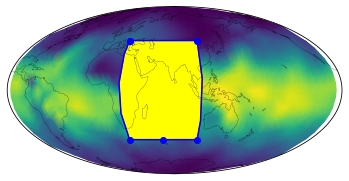

ZeroDivisionError: float division by zero

In [232]:
dataproj=crs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=crs.Orthographic()   # any projections should work 
plotproj = crs.NearsidePerspective(central_longitude=80.0, central_latitude=-30.0, satellite_height=3.5785831e7*1.)
#plotproj = ccrs.Orthographic(central_latitude=0.0, central_longitude=80.0)
plotproj=crs.Mollweide(central_longitude=80.0)   # any projections should work 

ax = pyplot.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)

ds_gridlr = xr.open_dataset(gridfile).rename({'grid_size': 'ncol'})
lon_edgeslr = ds_gridlr['grid_corner_lon']
lat_edgeslr = ds_gridlr['grid_corner_lat']

print('xxx',lon_edgeslr)
xx1 = np.array(lon[:])
print('xx1',xx1.shape)

tcoords = plotproj.transform_points(dataproj,np.array(lon[:]),np.array(lat[:]))
print('tcoords',tcoords.shape)
tcoord2 = plotproj.transform_points(dataproj,np.array(lon_edgeslr),np.array(lat_edgeslr))
print('tcoord2',tcoord2.shape)

data2d = data
print('data2d',data2d.shape)
xi=tcoords[:,0]!=numpy.inf
print('xi',xi.shape, xi[0])
tc=tcoords[xi,:]
print('tc',tc.shape)
datai=data2d[:][xi]  # convert to numpy array, then subset
print('datai',datai.shape)


#xi2=tcoord2[:,:,0]!=numpy.inf
#print('xi2',xi2.shape,xi2[:,0])
#tc2=tcoord2[xi2,:]
#print('tc2',tc2.shape)
#print('data2d',data2d)
#datai2=data2d[:][xi2]  # convert to numpy array, then subset
#print('datai2',datai2)

pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='gouraud') # looks good
#pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='flat') # looks bad

cube_lat = np.array([ 45.,45.,-45.,-45.,-45., 45.])
cube_lon = np.array([-90., 0.,  0.,-45.,-90.,-90.])+110.
poly_corners = np.zeros((len(cube_lat), 2), np.float64)
poly_corners[:,0] = cube_lon
poly_corners[:,1] = cube_lat
x = cube_lon
y = cube_lat

dataproj._threshold /= 100.
p2 = ccrs.PlateCarree()
#p2 = ccrs.Geodetic()
#p2._threshold /= 100.
p2 = dataproj


if hasattr(plotproj,'_threshold'):
    print('aaa',plotproj._threshold)
    plotproj._threshold /= 100.


def is_clockwise(points):
    # points is your list (or array) of 2d points.
    assert len(points) > 0
    s = 0.0
    for p1, p2 in zip(points, points[1:] + [points[0]]):
        s += (p2[0] - p1[0]) * (p2[1] + p1[1])
    return s > 0.0

print('winding', is_clockwise(poly_corners))

#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", alpha=1., transform=ccrs.Geodetic())
poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow", alpha=1., transform=p2)
#poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=True, lw=1, fc="yellow",alpha=0.4, transform=dataproj)
ax.add_patch(poly)
ax.plot(x, y, marker='o', color='blue',transform=p2)

plt.show()
1./0.
#ax.add_patch(poly)

proj3d = crs.Geocentric() 
x3d = proj3d.transform_points(dataproj,x, y)
ntcoords = plotproj.transform_points(proj3d,x3d[:,0],x3d[:,1],x3d[:,2])
print('ntcoords',ntcoords)
print(ntcoords[:,0:2].shape)
ntcoords2d = ntcoords[:,0:2]
print('ntcoords2d',ntcoords2d)

poly = mpatches.Polygon(ntcoords2d, closed=True, ec='r', fill=True, lw=1, fc="yellow",alpha=0.4, transform=plotproj)
ax.add_patch(poly)
plt.show
1./0.
# ugly code to bad stuff
x0=ntcoords[tri[:,0],0]
y0=ntcoords[tri[:,0],1]
x1=ntcoords[tri[:,1],0]
y1=ntcoords[tri[:,1],1]
x2=ntcoords[tri[:,2],0]
y2=ntcoords[tri[:,2],1]
d=numpy.empty(tri.shape)
d[:,0]=((x0-x1)**2 + (y0-y1)**2)**0.5
d[:,1]=((x0-x2)**2 + (y0-y2)**2)**0.5
d[:,2]=((x1-x2)**2 + (y1-y2)**2)**0.5
dmax=numpy.amax(d,axis=1)
gmin=numpy.nanmin(dmax[dmax != numpy.inf])
gmax=numpy.nanmax(dmax[dmax != numpy.inf])

mask = numpy.logical_or( dmax > 25*gmin, numpy.isnan(dmax))


1./0.
poly = mpatches.Polygon(tcoords, closed=True, ec='r', fill=True, lw=1, fc="yellow",alpha=0.4, transform=plotproj)
ax.add_patch(poly)


#print()
#ax.plot(x, y, marker='o', color='red',transform=dataproj)
#ax.fill(x, y, transform=dataproj, color='coral', alpha=0.4)

plt.show

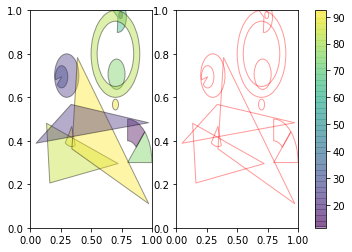

In [224]:
import numpy as np
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots(1,2)

resolution = 50  # the number of vertices
N = 3
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r)
    patches.append(circle)

x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
theta1 = 360.0*np.random.rand(N)
theta2 = 360.0*np.random.rand(N)
for x1, y1, r, t1, t2 in zip(x, y, radii, theta1, theta2):
    wedge = Wedge((x1, y1), r, t1, t2)
    patches.append(wedge)

# Some limiting conditions on Wedge
patches += [
    Wedge((.3, .7), .1, 0, 360),             # Full circle
    Wedge((.7, .8), .2, 0, 360, width=0.05),  # Full ring
    Wedge((.8, .3), .2, 0, 45),              # Full sector
    Wedge((.8, .3), .2, 45, 90, width=0.10),  # Ring sector
]

for i in range(N):
    polygon = Polygon(np.random.rand(N, 2), True)
    patches.append(polygon)

colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4,ec='black')
p2 = PatchCollection(patches, alpha=0.4,ec='red')
p2.set_facecolor('none')
p.set_array(colors)
ax[0].add_collection(p)
fig.colorbar(p, ax=ax)

ax[1].add_collection(p2)
#p2 = p.copy()
#p2.set_facecolor('none')

plt.show()

In [33]:

FSNS = 164.066
FLNS = 55.091
LH = 88.572
SH = 19.994
RES = FSNS-FLNS-LH-SH
print('RES',RES)
FSNS = 165.233
FLNS = 55.574
LH = 88.911
SH = 19.954
RES = FSNS-FLNS-LH-SH
print('RES2',RES)
print('roundoffissue', 0.07/160.)

RES 0.4089999999999918
RES2 0.794000000000004
roundoffissue 0.00043750000000000006


In [ ]:
FSNT=240.664
FLNT=240.075
FSNT-FLNT


In [ ]:
import os
inCmd='ncdump -h '+indir
outCmd = os.popen(inCmd).read()
print(inCmd)
print(outCmd)

In [ ]:
T = DS.T
print(T)

In [ ]:
#DS = xr.open_dataset('~/NetCDF_Files/vd05_ANN_climo.nc')
#print (DS.T) 
T = DS.T.isel(time=0)
#T?
TZ = T.mean(dim='lon')
#TZ?
lev = TZ['lev']
lat = TZ['lat']
vals = TZ.values
plotZMf(vals, lat, lev)


In [ ]:
TZ.plot()
plt.show()

In [ ]:
da = DS.PS# Draw coastlines of the Earth
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines() 



da.plot()
plt.show()

In [ ]:
TS = DS.TS# Draw coastlines of the Earth
TS = TS.isel(time=0)
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
lon = TS['lon']
lat = TS['lat']
ax.contourf(lon, lat, TS, transform=ccrs.PlateCarree())

da.plot()
plt.show()